# Import required Libraries :-


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
from PIL import Image
import tensorflow as tf
import pickle
import pathlib
import random
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns

In [2]:
rice_data_dir = pathlib.Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')
list(rice_data_dir.glob('*/*.jpg'))[:5]


[PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (11154).jpg'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8058).jpg'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5150).jpg'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8267).jpg'),
 PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (8747).jpg')]

# *Getting The number of Images in Dataset*

In [3]:
image_count = len(list(rice_data_dir.glob('*/*.jpg'))) 
print(image_count)

75000


# *listing all Arborio Images*

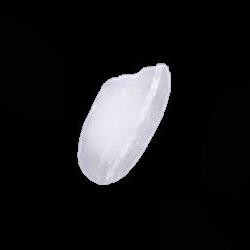

In [4]:
Arborio = list(rice_data_dir.glob('Arborio/*'))
PIL.Image.open(str(Arborio[0]))

# *listing all Basmati Images*

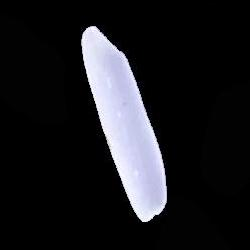

In [5]:
Basmati = list(rice_data_dir.glob('Basmati/*'))
PIL.Image.open(str(Basmati[0]))

# *listing all Ipsala Images*

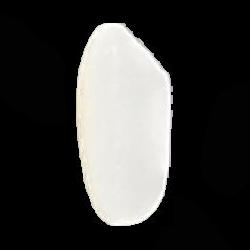

In [6]:
Ipsala = list(rice_data_dir.glob('Ipsala/*'))
PIL.Image.open(str(Ipsala[0]))

# *listing all Jasmine Images*

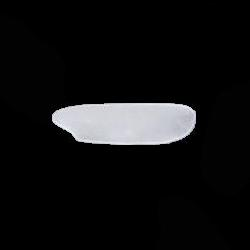

In [7]:
Jasmine = list(rice_data_dir.glob('Jasmine/*'))
PIL.Image.open(str(Jasmine[0]))

# *listing all Karacadag Images*

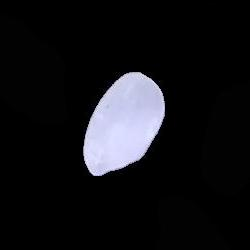

In [8]:
Karacadag = list(rice_data_dir.glob('Karacadag/*'))
PIL.Image.open(str(Karacadag[0]))

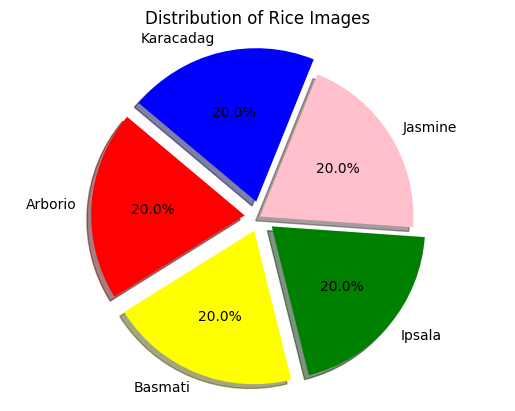

In [9]:
# Count the number of images in each class
Arborio_count = len(list(rice_data_dir.glob('Arborio/*.jpg')))
Basmati_count = len(list(rice_data_dir.glob('Basmati/*.jpg')))
Ipsala_count = len(list(rice_data_dir.glob('Ipsala/*.jpg')))
Jasmine_count = len(list(rice_data_dir.glob('Jasmine/*.jpg')))
Karacadag_count = len(list(rice_data_dir.glob('Karacadag/*.jpg')))


# Create a pie chart
labels = ['Arborio', 'Basmati', 'Ipsala','Jasmine','Karacadag']
sizes = [Arborio_count, Basmati_count,Ipsala_count,Jasmine_count, Karacadag_count]
colors = ['red', 'Yellow', 'green','pink','blue']
explode = (0.1, 0.1, 0.1,0,0.1)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Rice Images')
plt.show()

# *Making a dictionary for all rice Images*

In [10]:
rice_images_dict = {                             
    'Arborio': list(rice_data_dir.glob('Arborio/*')),
    'Basmati': list(rice_data_dir.glob('Basmati/*')),
    'Ipsala': list(rice_data_dir.glob('Ipsala/*')),
    'Jasmine': list(rice_data_dir.glob('Jasmine/*')),
    'Karacadag': list(rice_data_dir.glob('Karacadag/*')),
}

# *Making a dictionary for all rice labels*

In [11]:
rice_labels_dict = {
    'Arborio': 0,
    'Basmati': 1,
    'Ipsala': 2,
    'Jasmine':3,
    'Karacadag':4,

}

# *Separating The Features and Target and Resizing The Images*

In [12]:
X, y = [], []
for kind, images in rice_images_dict.items():
    for image in images:
        img = cv2.imread(str(image)) 
        resized_img = cv2.resize(img,(80,80))
        X.append(resized_img)
        y.append(rice_labels_dict[kind])

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
from sklearn.model_selection import train_test_split

# First, split into train and remaining (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 30% of the data is reserved for validation + test

# Further split the remaining set into validation and test sets (50% of 30% = 15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each set
print(f"Training set size: {len(X_train)} ({len(X_train) / len(X) * 100:.2f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val) / len(X) * 100:.2f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test) / len(X) * 100:.2f}%)")

Training set size: 52500 (70.00%)
Validation set size: 11250 (15.00%)
Test set size: 11250 (15.00%)


## Normalization

In [15]:
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0

## CNN

In [16]:
def create_model(conv_layers, dense_units, dropout_rate, num_classes):
    model = Sequential()
    for i in range(conv_layers):
        filters = 32 * (2 ** i)
        model.add(layers.Conv2D(filters, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

# Number of classes in dataset
num_classes = 5

# Create the model
model1 = create_model(conv_layers=5, dense_units=256, dropout_rate=0.25, num_classes=num_classes)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    factor=0.5,             # Factor to reduce the learning rate by
    patience=3,             # Number of epochs with no improvement before reducing
    min_lr=1e-6             # Minimum learning rate
)
# Training the model with early stopping
history = model1.fit(
    X_train_scaled, y_train,
    epochs=15,
    batch_size=16,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping,lr_scheduler]  
)

Epoch 1/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.8765 - loss: 0.3744 - val_accuracy: 0.9625 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 2/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9639 - loss: 0.1506 - val_accuracy: 0.9687 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 3/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9743 - loss: 0.1166 - val_accuracy: 0.9825 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 4/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9847 - loss: 0.0812 - val_accuracy: 0.9899 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 5/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9890 - loss: 0.0660 - val_accuracy: 0.9913 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 6/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9895 - loss: 0.0601 - val_accuracy: 0.9917 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 7/15
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.

# *Evaluating the Model*

In [17]:
evaluation = model1.evaluate(X_val_scaled, y_val)
print(f"Validation  Accuracy: {evaluation[1]}")

352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9956 - loss: 0.0332
Validation  Accuracy: 0.9945777654647827


# *Predictions*

In [18]:
predictions = model1.predict(X_val_scaled)

352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


# *Plotting Random Images with Predicted and True Class*

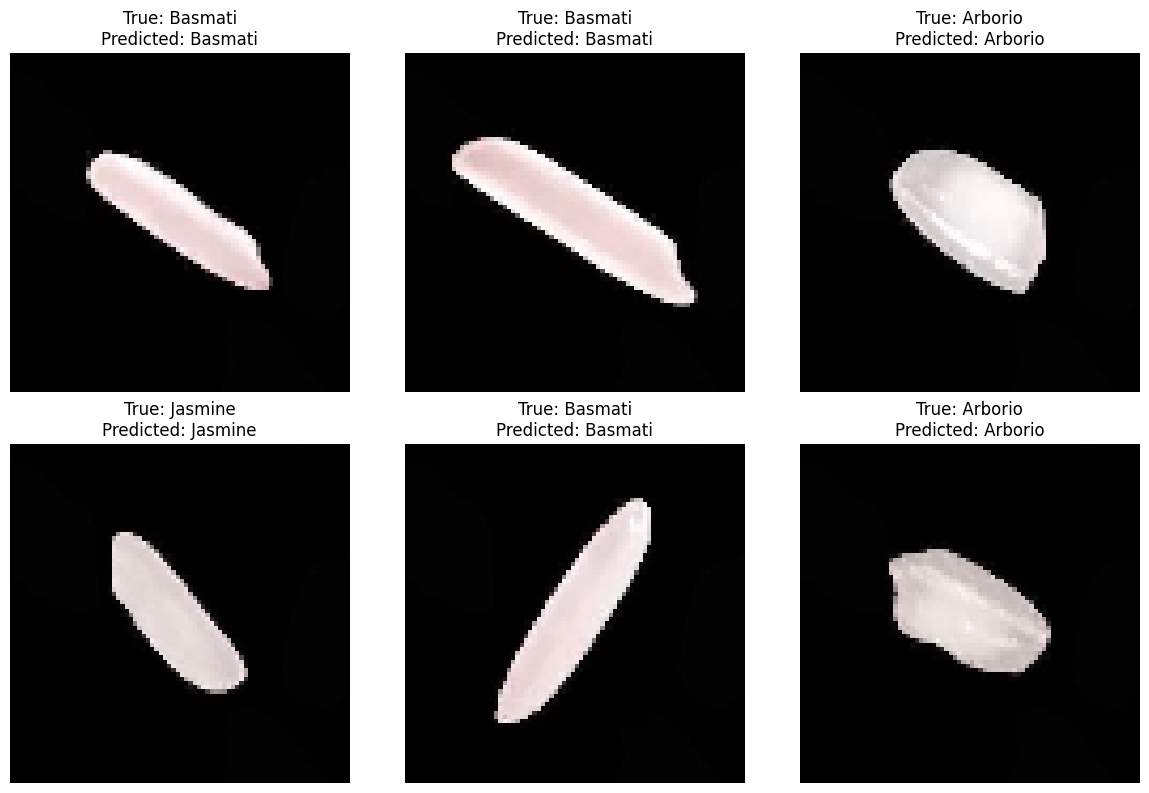

In [19]:

label_to_class = {idx: category for category, idx in rice_labels_dict.items()} # which maps the class indices to their respective category names
num_images_to_display = 6
random_indices = np.random.choice(len(X_val_scaled), num_images_to_display, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten() # flattens the 2D array of axes into a 1D array

for i, index in enumerate(random_indices):
    image = X_val_scaled[index]
    true_label = y_val[index]
    predicted_label = np.argmax(predictions[index])

    axes[i].imshow(image)
    axes[i].set_title(f"True: {label_to_class[true_label]}\nPredicted: {label_to_class[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# *Plot Training & Validation Accuracy and Loss*

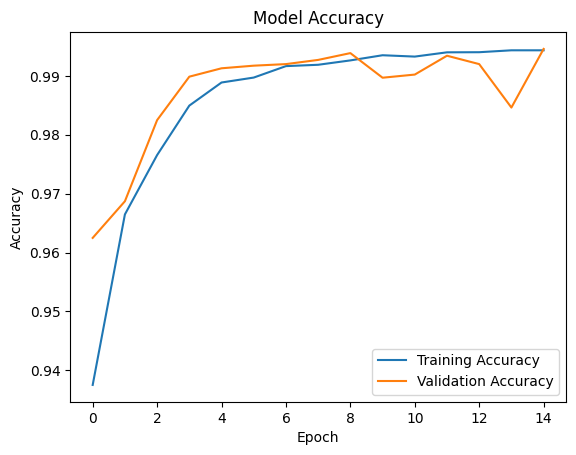

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

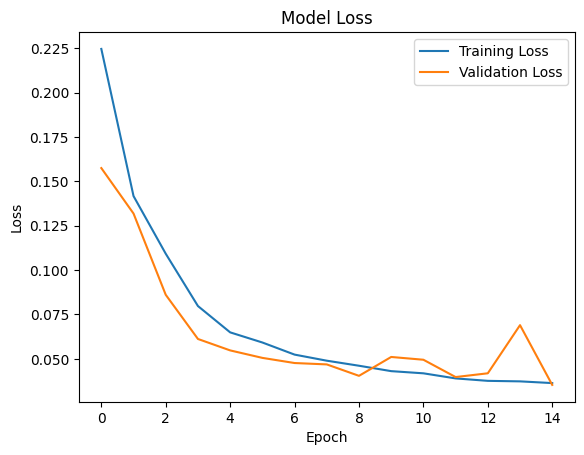

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [22]:

y_pred = np.argmax(predictions, axis=1)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2243
           1       1.00      0.99      1.00      2248
           2       1.00      1.00      1.00      2282
           3       0.99      1.00      0.99      2217
           4       0.99      1.00      1.00      2260

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



# *Confusion Matrix*

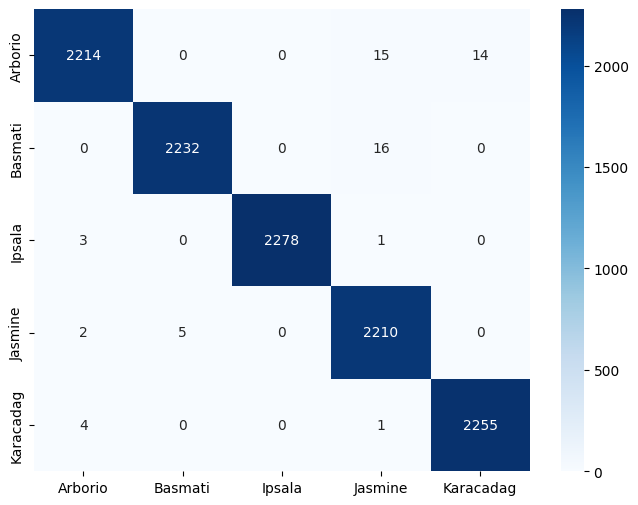

In [23]:

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_class.values(), yticklabels=label_to_class.values())
plt.show()

## **The Performance of our Model on Test Data**

## Normalization The test Data

In [24]:
X_test_Scaled=X_test/255.0

In [25]:
evaluation = model1.evaluate(X_test_Scaled, y_test)
print(f"Testing  Accuracy: {evaluation[1]}")

352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9960 - loss: 0.0324
Testing  Accuracy: 0.9961777925491333


In [26]:
predictions_test = model1.predict(X_test_Scaled)

352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


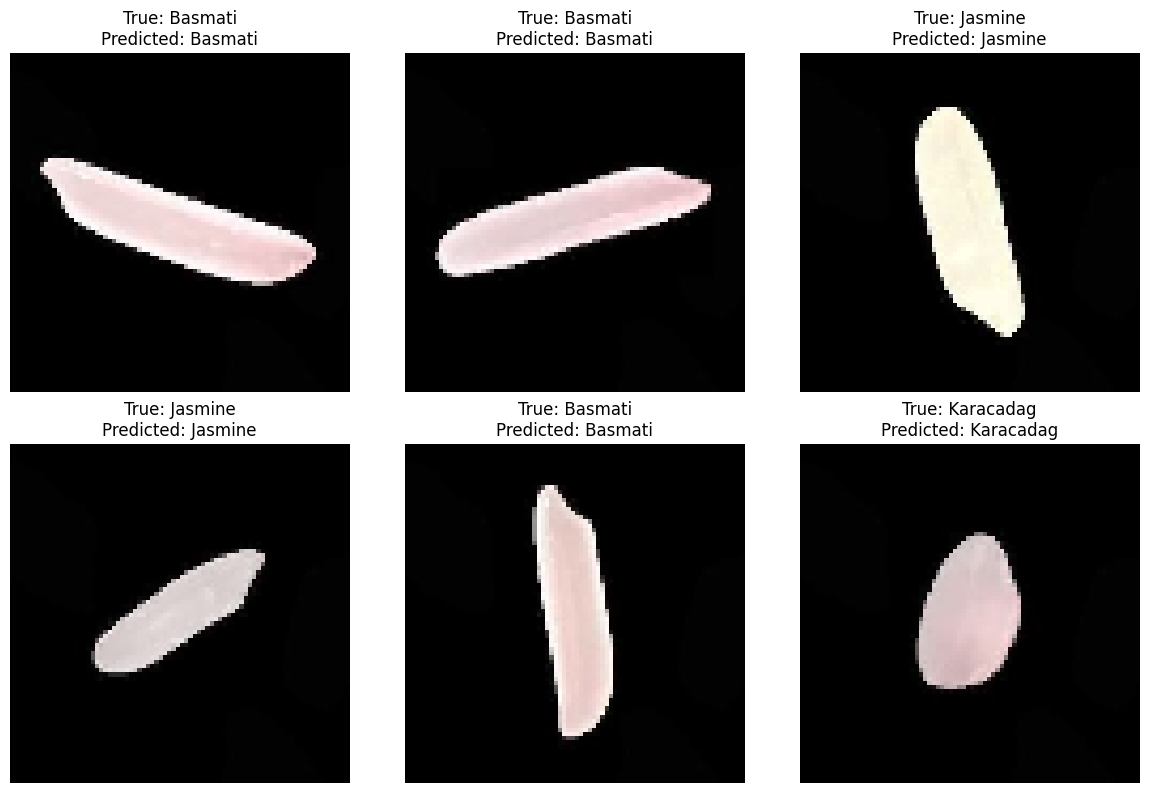

In [27]:

label_to_class = {idx: category for category, idx in rice_labels_dict.items()} # which maps the class indices to their respective category names
num_images_to_display = 6
random_indices = np.random.choice(len(X_test_Scaled), num_images_to_display, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, index in enumerate(random_indices):
    image = X_test_Scaled[index]
    true_label = y_test[index]
    predicted_label = np.argmax(predictions_test[index])

    axes[i].imshow(image)
    axes[i].set_title(f"True: {label_to_class[true_label]}\nPredicted: {label_to_class[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [28]:
y_pred_test = np.argmax(predictions_test, axis=1)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2229
           1       1.00      1.00      1.00      2227
           2       1.00      1.00      1.00      2368
           3       0.99      0.99      0.99      2261
           4       1.00      1.00      1.00      2165

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250



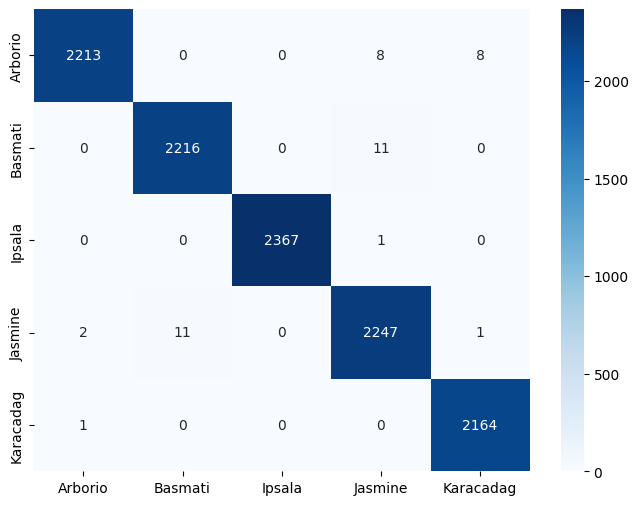

In [29]:
# *Confusion Matrix*
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_class.values(), yticklabels=label_to_class.values())
plt.show()